In [1]:
import os
os.chdir('..')

# Data Integration and Aggregation

Joins and aggregation efficiently



In [2]:
from pyspark.sql.session import SparkSession
from src.config.config import (CUSTOMER_DATASET,
                               ORDER_DATASET,
                               ORDER_ITEMS_DATASET,
                               ORDER_PAYMENTS_DATASET,
                               ORDER_REVIEWS_DATASET,
                               PRODUCTS_DATASET,
                               SELLERS_DATASET,
                               GEOLOCATION_DATASET,
                               PRODUCT_TRANSLATIONS
                               )

spark = SparkSession.builder.appName('oblist').getOrCreate()

spark

In [3]:
hdfs_path = 'data/olist/'

customer_dataset = spark.read.csv(hdfs_path + CUSTOMER_DATASET, header=True, inferSchema=True)
order_dataset = spark.read.csv(hdfs_path + ORDER_DATASET, header=True, inferSchema=True)
items_dataset = spark.read.csv(hdfs_path + ORDER_ITEMS_DATASET, header=True, inferSchema=True)
payments_dataset = spark.read.csv(hdfs_path + ORDER_PAYMENTS_DATASET, header=True, inferSchema=True)
reviews_dataset = spark.read.csv(hdfs_path + ORDER_REVIEWS_DATASET, header=True, inferSchema=True)
geolocation_dataset = spark.read.csv(hdfs_path + GEOLOCATION_DATASET, header=True, inferSchema=True)
products_dataset = spark.read.csv(hdfs_path + PRODUCTS_DATASET, header=True, inferSchema=True)
sellers_dataset = spark.read.csv(hdfs_path + SELLERS_DATASET, header=True, inferSchema=True)
translations = spark.read.csv(hdfs_path + PRODUCT_TRANSLATIONS, header=True, inferSchema=True)

### JOIN

In [4]:
# jpin orders with items
orders_items_df = order_dataset.join(items_dataset, 'order_id', 'inner')

In [5]:
# join products
orders_items_products_df = orders_items_df.join(products_dataset, 'product_id', 'inner')

In [6]:
# join with sellers 
orders_items_products_sellers_df = orders_items_products_df.join(sellers_dataset, 'seller_id', 'inner')

In [7]:
# join customeers
full_orders = orders_items_products_sellers_df.join(customer_dataset, 'customer_id', 'inner')

In [8]:
from pyspark.sql.functions import mode

In [9]:
from pyspark.sql.functions import mean

geo_mean_lat = geolocation_dataset.groupBy('geolocation_zip_code_prefix').agg(mean('geolocation_lat').alias('geo_lat_mean'))
geo_mean_lng = geolocation_dataset.groupBy('geolocation_zip_code_prefix').agg(mean('geolocation_lng').alias('geo_mean_lng'))
city_zip_code = geolocation_dataset.groupBy('geolocation_zip_code_prefix').agg(mode('geolocation_city').alias('geolocation_city'))


geolocation_avg = (
        geolocation_dataset
            .select('geolocation_zip_code_prefix', 'geolocation_state')
            .dropDuplicates()) \
                .join(city_zip_code, 'geolocation_zip_code_prefix', 'inner') \
                .join(geo_mean_lat, 'geolocation_zip_code_prefix', 'inner') \
                .join(geo_mean_lng, 'geolocation_zip_code_prefix', 'inner')


In [10]:
# join geolocation
full_orders_geo_customer=full_orders.join(geolocation_avg, 
                            full_orders.customer_zip_code_prefix == geolocation_avg.geolocation_zip_code_prefix, 
                            'left')



In [11]:

# named_columns = {'geo_lat_mean': 'customer_geo_lat_mean',
#                  'geo_mean_lng': 'customer_geo_lng_mean'}

# full_orders_geo_customer=full_orders_geo_customer.withColumnsRenamed(named_columns)

In [12]:
geo_cols = geolocation_avg.columns 

for col in geo_cols:
    full_orders_geo_customer = full_orders_geo_customer.withColumnRenamed(existing=col, new='customer_'+col)

In [13]:
full_orders_geo_seller=full_orders_geo_customer.join(geolocation_avg, 
                            full_orders_geo_customer.seller_zip_code_prefix == geolocation_avg.geolocation_zip_code_prefix, 
                            'left')

In [14]:
for col in geo_cols:
    full_orders_geo_seller = full_orders_geo_seller.withColumnRenamed(existing=col, new='seller_'+col)

In [15]:
# JOIN reviews
full_orders_reviews = full_orders_geo_seller.join(reviews_dataset, 'order_id', 'left')

In [16]:
# join payments
full_orders = full_orders_reviews.join(payments_dataset, 'order_id', 'left')

Repartition


In [17]:
full_orders.show()

+--------------------+--------------------+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+-------------------+------+-------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+----------------------+--------------------+------------+--------------------+------------------------+-------------+--------------+------------------------------------+--------------------------+-------------------------+---------------------+---------------------+----------------------------------+------------------------+-----------------------+-------------------+-------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+------------------+------------+----------

In [18]:
columns = full_orders.columns
columns_to_remove =  [
'customer_geolocation_city',
 'customer_geolocation_zip_code_prefix',
 'seller_geolocation_zip_code_prefix',
 'seller_geolocation_state',
 'seller_geolocation_city']

for r in columns_to_remove:
    columns.remove(r)

columns.sort()

In [19]:
full_orders = full_orders.select(columns)

In [20]:
# coalesce the number of partition to improve performance
full_orders = full_orders.coalesce(4)

Total Revenue by Seller

In [21]:
from pyspark.sql.functions import sum

In [22]:
full_orders.groupBy('seller_id').agg(sum('price')).orderBy('sum(price)', ascending=False).show()

+--------------------+------------------+
|           seller_id|        sum(price)|
+--------------------+------------------+
|53243585a1d6dc264...|244627.54999999964|
|4869f7a5dfa277a7d...|238386.12999999808|
|4a3ca9315b744ce9f...|215968.56999999454|
|fa1c13f2614d7b5c4...|203984.21999999823|
|7c67e1448b00f6e96...|201568.00999999946|
|7e93a43ef30c4f03f...|182878.16999999993|
|da8622b14eb17ae28...|171814.46999999468|
|7a67c85e85bb2ce85...|150779.78000000105|
|1025f0e2d44d7041d...|144500.52999999933|
|955fee9216a65b617...|137404.99999999895|
|46dc3b2cc0980fb8e...| 132322.0200000011|
|6560211a19b47992c...|128958.81000000006|
|7d13fca1522535862...|121677.83999999987|
|5dceca129747e92ff...|120619.32999999961|
|620c87c171fb2a6dd...|119489.19999999813|
|1f50f920176fa81da...|111928.00999999713|
|cc419e0650a3c5ba7...|110935.25000000311|
|a1043bafd471dff53...|106813.94000000072|
|3d871de0142ce09b7...| 99556.59999999969|
|edb1ef5e36e0c8cd8...| 81220.14999999994|
+--------------------+------------

In [23]:
from pyspark.sql.functions import udf
import math
from pyspark.sql.types import FloatType


In [24]:
import math
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, StringType

# --- 1. Define the core Haversine function ---
def haversine_distance(lat1, lon1, lat2, lon2, unit='km'):
    """
    Calculates the Haversine distance between two points on the Earth
    (specified in decimal degrees).

    The Haversine formula is used to compute the great-circle distance
    between two points on a sphere from their longitudes and latitudes.

    Args:
        lat1 (float): Latitude of the first point.
        lon1 (float): Longitude of the first point.
        lat2 (float): Latitude of the second point.
        lon2 (float): Longitude of the second point.
        unit (str): The desired unit for the output distance. Can be 'km'
                    (kilometers) or 'mi' (miles). Defaults to 'km'.

    Returns:
        float: The distance between the two points in the specified unit.
    """
    # Radius of the Earth in kilometers or miles
    if unit == 'km':
        R = 6371.0
    elif unit == 'mi':
        R = 3958.8
    else:
        raise ValueError("Unit must be 'km' or 'mi'")

    # Convert coordinates from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Calculate the differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c

    return float(distance)


# --- 2. Register the function as a PySpark UDF ---
# PySpark UDFs need a return type specified.
haversine_udf = F.udf(haversine_distance, FloatType())
haversine_udf_km = F.udf(lambda lat1, lon1, lat2, lon2: haversine_distance(lat1, lon1, lat2, lon2, unit='km'), FloatType())
haversine_udf_mi = F.udf(lambda lat1, lon1, lat2, lon2: haversine_distance(lat1, lon1, lat2, lon2, unit='mi'), FloatType())


In [25]:
from pyspark.sql.functions import col

In [26]:
# full_orders.withColumn('distance_customer_seller', 
#                        haversine_udf_km('seller_geo_lat_mean', 
#                                           'seller_geo_mean_lng', 
#                                           'customer_geo_lat_mean', 
#                                           'customer_geo_mean_lng')
#                        )

### Save data

In [27]:
full_orders\
    .write\
        .mode('overwrite')\
            .parquet(
                os.path.join('data', 'olist_processed', 'full_data.parquet')
                )

# Advanced Aggregation and Window Functions

### Optimized Joins 

### Broadcast Join

PySpark broadcast join is an optimization technique used in Apache Spark to improve the performance of join operations, particularly when one of the DataFrames involved in the join is significantly smaller than the other. 


Instead of shuffling both DataFrames across the network for the join, the smaller DataFrame is broadcasted (sent) to all worker nodes in the Spark cluster. This means each worker node receives a complete copy of the smaller DataFrame and stores it in its memory.

In [28]:
from pyspark.sql.functions import (broadcast)

In [29]:
# sellers dataset is the smallest dataset in mb, so broadcast it 
# to join would improve the merge operation


In [30]:
# old operation
import time 


tic = time.time()
orders_sellers_nobroad = orders_items_products_df.join(sellers_dataset, 'seller_id', 'inner')
orders_sellers_nobroad.show(5)
tac = time.time()

print('Joining without broadcast:', str(tac-tic))

+--------------------+--------------------+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+-------------------+-----+-------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+----------------------+-----------+------------+
|           seller_id|          product_id|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|shipping_limit_date|price|freight_value|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|seller_zip_code_prefix|seller_city|seller_state|
+-------------

In [31]:
# brodcast
tic = time.time()

orders_products_broad = orders_items_products_df.join(
    broadcast(sellers_dataset), 
    'seller_id', 
    'inner'
)
orders_products_broad.show(5)

tac = time.time()

print('time with broadcast:', str(tac-tic))

+--------------------+--------------------+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+-------------------+-----+-------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+----------------------+-----------+------------+
|           seller_id|          product_id|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|shipping_limit_date|price|freight_value|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|seller_zip_code_prefix|seller_city|seller_state|
+-------------

In [32]:
# asdasdas
full_orders.cache()

DataFrame[customer_city: string, customer_geo_lat_mean: double, customer_geo_mean_lng: double, customer_geolocation_state: string, customer_id: string, customer_state: string, customer_unique_id: string, customer_zip_code_prefix: int, freight_value: double, order_approved_at: timestamp, order_delivered_carrier_date: timestamp, order_delivered_customer_date: timestamp, order_estimated_delivery_date: timestamp, order_id: string, order_item_id: int, order_purchase_timestamp: timestamp, order_status: string, payment_installments: int, payment_sequential: int, payment_type: string, payment_value: double, price: double, product_category_name: string, product_description_lenght: int, product_height_cm: int, product_id: string, product_length_cm: int, product_name_lenght: int, product_photos_qty: int, product_weight_g: int, product_width_cm: int, review_answer_timestamp: string, review_comment_message: string, review_comment_title: string, review_creation_date: string, review_id: string, revie

## Aggregations

In [33]:
# total orders per customers
customer_order_counts = full_orders.groupBy('customer_id').count().orderBy('count', ascending=False)
customer_order_counts.show(10)

+--------------------+-----+
|         customer_id|count|
+--------------------+-----+
|270c23a11d024a44c...|   63|
|13aa59158da63ba0e...|   38|
|9af2372a1e4934027...|   29|
|92cd3ec6e2d643d4e...|   26|
|63b964e79dee32a35...|   24|
|d22f25a9fadfb1abb...|   24|
|6ee2f17e3b6c33d6a...|   24|
|2ba91e12e5e4c9f56...|   24|
|86cc80fef09f7f39d...|   24|
|be1c4e52bb71e0c54...|   22|
+--------------------+-----+
only showing top 10 rows



In [34]:
# avg review per seller
seller_review = full_orders.groupBy('seller_id').agg(mean('review_score').alias('score')).orderBy('score', ascending=False)
seller_review.show(5)

+--------------------+-----+
|           seller_id|score|
+--------------------+-----+
|5741dc2bf5044c34d...|  5.0|
|1cd9e0cc1839d5551...|  5.0|
|89757206b887aed36...|  5.0|
|f1fdf2d1318657575...|  5.0|
|a61cc04793308395a...|  5.0|
+--------------------+-----+
only showing top 5 rows



In [35]:
# most sold products
from pyspark.sql.functions import count

top_sold = full_orders.groupBy('product_id').agg(count('order_id').alias('total_units_sold')).orderBy('total_units_sold', ascending=False).limit(10)
top_sold.show(10)

+--------------------+----------------+
|          product_id|total_units_sold|
+--------------------+----------------+
|aca2eb7d00ea1a7b8...|             536|
|99a4788cb24856965...|             528|
|422879e10f4668299...|             508|
|389d119b48cf3043d...|             406|
|368c6c730842d7801...|             398|
|53759a2ecddad2bb8...|             391|
|d1c427060a0f73f6b...|             357|
|53b36df67ebb7c415...|             327|
|154e7e31ebfa09220...|             296|
|3dd2a17168ec895c7...|             279|
+--------------------+----------------+



In [36]:
# top 10 customers by spending
customers_top = full_orders.groupBy('customer_id').agg(sum('price').alias('total_spend')).orderBy('total_spend', ascending=False).limit(10)
customers_top.show()

+--------------------+------------------+
|         customer_id|       total_spend|
+--------------------+------------------+
|1617b1357756262bf...|           13440.0|
|9af2372a1e4934027...|11383.949999999997|
|de832e8dbb1f588a4...|10856.099999999999|
|63b964e79dee32a35...|            9888.0|
|6f241d5bbb142b6f7...| 9520.140000000001|
|926b6a6fb8b6081e0...|            7998.0|
|f959b7bc834045511...|            7799.4|
|eb7a157e8da9c488c...|            7798.0|
|ec5b2ba62e5743423...|            7160.0|
|3118aefef04e5e97d...|            6909.0|
+--------------------+------------------+



## Window Functions and Ranking

In [37]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, rank

In [38]:
# rank top selling products per seller

window_spc = Window.partitionBy('seller_id').orderBy(desc('price'))

In [39]:
top_seller_product = full_orders.withColumn('rank', rank().over(window=window_spc))
top_seller_product.show()

+-------------------+---------------------+---------------------+--------------------------+--------------------+--------------+--------------------+------------------------+-------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+------------------+------------+-------------+------+---------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+-----------------------+----------------------+--------------------+--------------------+--------------------+------------+-------------------+-------------------+-------------------+--------------------+------------+----------------------+-------------------+----+
|      customer_city|customer_geo_lat_mean|customer_geo_mean_lng|customer_geolocation_state|         customer_i

In [40]:
top_seller_product.select('seller_id', 'product_id', 'price', 'rank').distinct().orderBy(['seller_id', 'rank']).show(50, truncate=False)

+--------------------------------+--------------------------------+-----+----+
|seller_id                       |product_id                      |price|rank|
+--------------------------------+--------------------------------+-----+----+
|0015a82c2db000af6aaaf3ae2ecb0532|a2ff5a97bf95719e38ea2e3b4105bce8|895.0|1   |
|001cca7ae9ae17fb1caed9dfb1094831|e251ebd2858be1aa7d9b2087a6992580|199.0|1   |
|001cca7ae9ae17fb1caed9dfb1094831|98a8c2fa16d7239c606640f5555768e4|169.0|2   |
|001cca7ae9ae17fb1caed9dfb1094831|e251ebd2858be1aa7d9b2087a6992580|139.9|3   |
|001cca7ae9ae17fb1caed9dfb1094831|6d15a14a5c04e3ef315ab136bd824d72|139.9|3   |
|001cca7ae9ae17fb1caed9dfb1094831|e251ebd2858be1aa7d9b2087a6992580|139.0|9   |
|001cca7ae9ae17fb1caed9dfb1094831|547b95702aec86f05ac37e61d164891c|135.0|13  |
|001cca7ae9ae17fb1caed9dfb1094831|08574b074924071f4e201e151b152b4e|135.0|13  |
|001cca7ae9ae17fb1caed9dfb1094831|d32f22e03fb01595aa10383f4364d303|129.9|16  |
|001cca7ae9ae17fb1caed9dfb1094831|547b95702aec86f05a

In [41]:
# dense rank for seller based on product revenue
from pyspark.sql.functions import dense_rank

window_spc = Window.partitionBy(['seller_id']).orderBy(desc('total_revenue_product'))

In [42]:
renevue_per_product = full_orders\
    .groupBy(['seller_id', 'product_id'])\
        .agg(sum('price').alias('total_revenue_product'))\
        .withColumn('rank', dense_rank().over(window_spc))\
        .orderBy('seller_id', 'rank')


renevue_per_product.show()

+--------------------+--------------------+---------------------+----+
|           seller_id|          product_id|total_revenue_product|rank|
+--------------------+--------------------+---------------------+----+
|0015a82c2db000af6...|a2ff5a97bf95719e3...|               2685.0|   1|
|001cca7ae9ae17fb1...|08574b074924071f4...|              10928.2|   1|
|001cca7ae9ae17fb1...|e251ebd2858be1aa7...|    5592.099999999999|   2|
|001cca7ae9ae17fb1...|98a8c2fa16d7239c6...|               3424.9|   3|
|001cca7ae9ae17fb1...|547b95702aec86f05...|               2040.5|   4|
|001cca7ae9ae17fb1...|0da9ffd92214425d8...|              1819.93|   5|
|001cca7ae9ae17fb1...|86b22a03cb72239dd...|                658.0|   6|
|001cca7ae9ae17fb1...|21fecd254a3103704...|                337.0|   7|
|001cca7ae9ae17fb1...|4d7fee7877228c149...|                178.0|   8|
|001cca7ae9ae17fb1...|6d15a14a5c04e3ef3...|                139.9|   9|
|001cca7ae9ae17fb1...|d32f22e03fb01595a...|                129.9|  10|
|001cc

## Advanced Aggregation 

In [43]:
from pyspark.sql.functions import round, avg

Multiple Aggregations

In [44]:
# total revenue | average order value AOV per customer
customer_spending = full_orders.groupBy('customer_id') \
    .agg(
        count('order_id').alias('total_orders'),
        round(sum('price'),0).alias('total_spent'),
        round(avg('price'), 2).alias('AOV')
    ) \
    .orderBy('total_spent', ascending=False)

customer_spending.show()

+--------------------+------------+-----------+-------+
|         customer_id|total_orders|total_spent|    AOV|
+--------------------+------------+-----------+-------+
|1617b1357756262bf...|           8|    13440.0| 1680.0|
|9af2372a1e4934027...|          29|    11384.0| 392.55|
|de832e8dbb1f588a4...|          15|    10856.0| 723.74|
|63b964e79dee32a35...|          24|     9888.0|  412.0|
|6f241d5bbb142b6f7...|           7|     9520.0|1360.02|
|926b6a6fb8b6081e0...|           2|     7998.0| 3999.0|
|f959b7bc834045511...|           6|     7799.0| 1299.9|
|eb7a157e8da9c488c...|           2|     7798.0| 3899.0|
|ec5b2ba62e5743423...|           4|     7160.0| 1790.0|
|3118aefef04e5e97d...|           7|     6909.0|  987.0|
|c6e2731c5b391845f...|           1|     6735.0| 6735.0|
|f48d464a0baaea338...|           1|     6729.0| 6729.0|
|3fd6777bbce08a352...|           1|     6499.0| 6499.0|
|46bb3c0b1a65c8399...|           2|     6248.0| 3124.0|
|d1ea705f2fdd8f98e...|          14|     6020.0| 

Seller Performance Metrics

In [45]:
from pyspark.sql.types import FloatType

full_orders=full_orders.withColumn('review_score', col('review_score').cast(FloatType()))

In [46]:
# renenue, average review, order count
seller_performance = full_orders \
    .groupBy('seller_id') \
    .agg(
        round(sum('price'), 4).alias('total_revenue'),
        round(avg('review_score'), 1).alias('avg_review_score'),
        count('order_id').alias('orders_count')
        ) \
    .orderBy(['total_revenue', 'avg_review_score'], ascending=[False, False])

seller_performance.show()

+--------------------+-------------+----------------+------------+
|           seller_id|total_revenue|avg_review_score|orders_count|
+--------------------+-------------+----------------+------------+
|53243585a1d6dc264...|    244627.55|             4.1|         437|
|4869f7a5dfa277a7d...|    238386.13|             4.1|        1189|
|4a3ca9315b744ce9f...|    215968.57|             3.8|        2157|
|fa1c13f2614d7b5c4...|    203984.22|             4.3|         609|
|7c67e1448b00f6e96...|    201568.01|             3.4|        1473|
|7e93a43ef30c4f03f...|    182878.17|             4.2|         352|
|da8622b14eb17ae28...|    171814.47|             4.1|        1663|
|7a67c85e85bb2ce85...|    150779.78|             4.2|        1246|
|1025f0e2d44d7041d...|    144500.53|             3.9|        1482|
|955fee9216a65b617...|     137405.0|             4.1|        1530|
|46dc3b2cc0980fb8e...|    132322.02|             4.2|         559|
|6560211a19b47992c...|    128958.81|             3.9|        2

Location Sellers with Revenue

In [47]:
revenue_zipcode=full_orders.groupBy('seller_zip_code_prefix')\
    .agg(
        mean('seller_geo_lat_mean').alias('lat'), 
        mean('seller_geo_mean_lng').alias('lon'),
        sum('price').alias('total_spent')
        )\
    .toPandas()

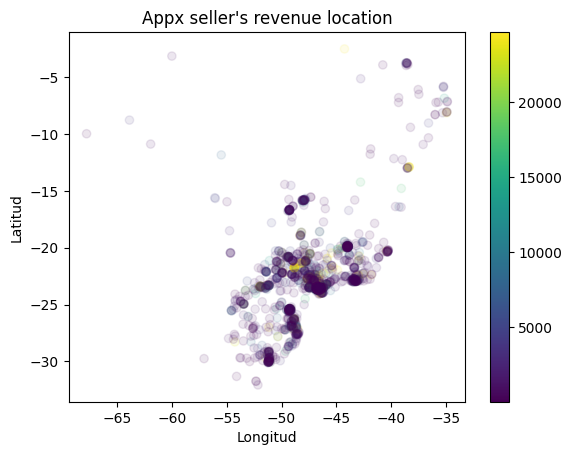

In [48]:
import matplotlib.pyplot as plt
import numpy as np

percentile_95 = np.percentile(revenue_zipcode['total_spent'], 95)


plt.scatter(x=revenue_zipcode['lon'], 
            y=revenue_zipcode['lat'], 
            c=revenue_zipcode['total_spent'].clip(0, percentile_95),
            cmap='viridis',
            alpha=((revenue_zipcode['total_spent'] - revenue_zipcode['total_spent'].min()) / (revenue_zipcode['total_spent'].max() - revenue_zipcode['total_spent'].min())).clip(0.1, 1.),
            )

plt.title("Appx seller's revenue location")
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar();

In [49]:
# product popularity metrics
from pyspark.sql.functions import collect_set

products_metrics = full_orders \
    .groupBy('product_id') \
        .agg(
            count('order_id').alias('total_sales'),
            round(sum('price'), 2).alias('total_revenue'),
            round(avg('price')).alias('avg_price'),
            collect_set('seller_id').alias('sellers_list')
        ) \
        .orderBy(desc('total_sales'))

products_metrics.limit(50).show(50)

+--------------------+-----------+-------------+---------+--------------------+
|          product_id|total_sales|total_revenue|avg_price|        sellers_list|
+--------------------+-----------+-------------+---------+--------------------+
|aca2eb7d00ea1a7b8...|        536|      38248.2|     71.0|[955fee9216a65b61...|
|99a4788cb24856965...|        528|     46575.66|     88.0|[4a3ca9315b744ce9...|
|422879e10f4668299...|        508|     27851.62|     55.0|[1f50f920176fa81d...|
|389d119b48cf3043d...|        406|     22181.19|     55.0|[1f50f920176fa81d...|
|368c6c730842d7801...|        398|      21601.1|     54.0|[1f50f920176fa81d...|
|53759a2ecddad2bb8...|        391|      21390.7|     55.0|[1f50f920176fa81d...|
|d1c427060a0f73f6b...|        357|      49141.4|    138.0|[a1043bafd471dff5...|
|53b36df67ebb7c415...|        327|     38158.21|    117.0|[7d13fca152253586...|
|154e7e31ebfa09220...|        296|      6669.04|     23.0|[cc419e0650a3c5ba...|
|3dd2a17168ec895c7...|        279|      

In [61]:
# monthly revenue and order count trend
from pyspark.sql.functions import month, stddev, min, max
from pyspark.sql.window import Window

window_spc = Window.orderBy('month').rowsBetween(Window.unboundedPreceding, Window.currentRow)

monthly_data = full_orders \
    .select('price','order_purchase_timestamp', 'order_id') \
    .withColumn('month', month('order_purchase_timestamp'))

monthly_group_data = monthly_data \
    .groupBy('month') \
        .agg(
            count('order_id').alias('total_orders'),
            round(sum('price'),4).alias('total_revenue'),
            round(avg('price'), 2).alias('average_revenue_per_order'),
            round(stddev('price'),4).alias('variability_price_order'),
            round(min('price'), 2).alias('min_price_order'),
            round(max('price'), 2).alias('max_price_order'),

        ).orderBy('month')

monthly_group_data = monthly_group_data.withColumn('cummulative_revenue', sum('total_revenue').over(window_spc))
monthly_group_data = monthly_group_data.withColumn('cummulative_orders', sum('total_orders').over(window_spc))

In [62]:
monthly_group_data.show()

+-----+------------+-------------+-------------------------+-----------------------+---------------+---------------+--------------------+------------------+
|month|total_orders|total_revenue|average_revenue_per_order|variability_price_order|min_price_order|max_price_order| cummulative_revenue|cummulative_orders|
+-----+------------+-------------+-------------------------+-----------------------+---------------+---------------+--------------------+------------------+
|    1|        9631|   1124076.85|                   116.71|               162.3445|            2.9|         3690.0|          1124076.85|              9631|
|    2|       10101|   1151947.94|                   114.04|                174.319|           2.99|         6735.0|          2276024.79|             19732|
|    3|       11800|   1428606.06|                   121.07|               182.7432|            4.9|        4099.99|          3704630.85|             31532|
|    4|       11141|   1424473.91|                   127.8

In [68]:
monthly_group_df = monthly_group_data.toPandas()

In [71]:
monthly_group_df.set_index('month', inplace=True)

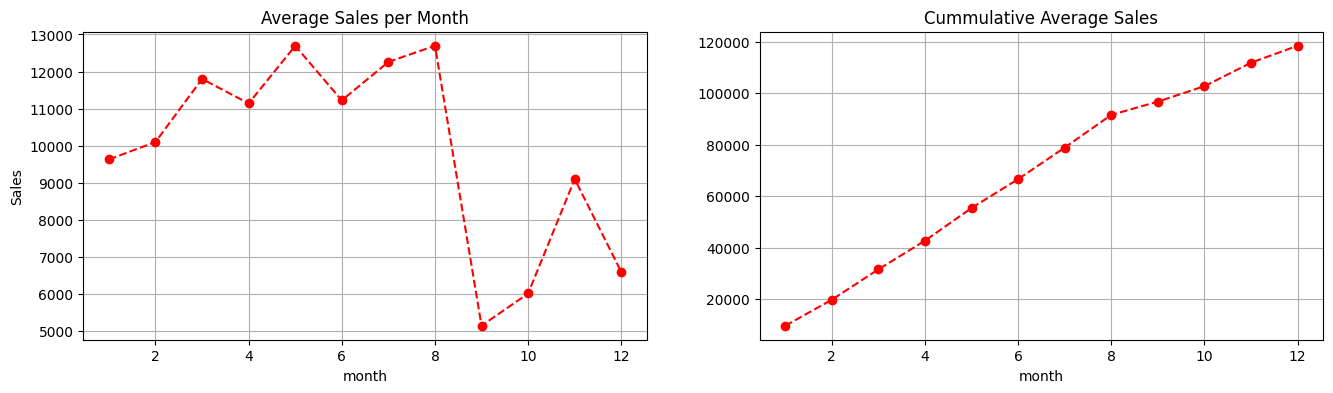

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

monthly_group_df.plot.line(y='total_orders', 
                           marker='o', 
                           linestyle='--', 
                           color='red', 
                           grid=True, 
                           legend=False,
                           ax = ax[0])
ax[0].set_ylabel('Sales')
ax[0].set_title('Average Sales per Month')

monthly_group_df.plot.line(y='cummulative_orders', 
                           marker='o', 
                           linestyle='--', 
                           color='red', 
                           grid=True, 
                           legend=False,
                           ax=ax[1])
ax[1].set_title('Cummulative Average Sales')
plt.show()

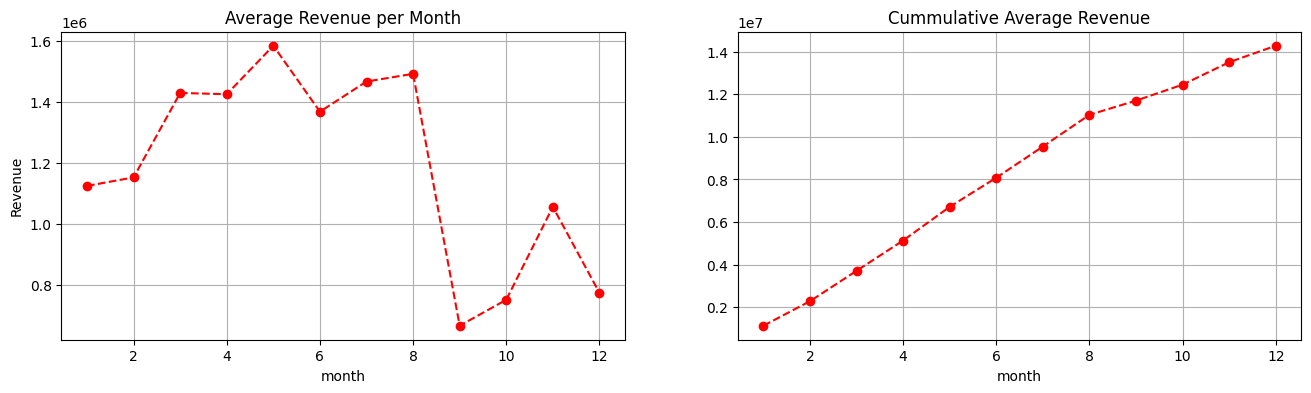

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

monthly_group_df.plot.line(y='total_revenue', 
                           marker='o', 
                           linestyle='--', 
                           color='red', 
                           grid=True, 
                           legend=False,
                           ax = ax[0])
ax[0].set_ylabel('Revenue')
ax[0].set_title('Average Revenue per Month')

monthly_group_df.plot.line(y='cummulative_revenue', 
                           marker='o', 
                           linestyle='--', 
                           color='red', 
                           grid=True, 
                           legend=False,
                           ax=ax[1])
ax[1].set_title('Cummulative Average Revenue')
plt.show()

Customer Retention Analysis 

In [128]:
from pyspark.sql.functions import first, last, date_diff

customer_retention = full_orders \
    .orderBy('order_purchase_timestamp') \
    .groupBy(['customer_id', 'order_id']) \
    .agg(
        first('order_purchase_timestamp').alias('first_purchase_date'),
        last('order_purchase_timestamp').alias('last_purchase_date'),
        count('order_id').alias('total_orders'),
        round(avg('price')).alias('aov')
    )\
    .orderBy('total_orders') \
    .withColumn('days_diff', date_diff('last_purchase_date', 'first_purchase_date'))

In [129]:
customer_retention.show()

+--------------------+--------------------+-------------------+-------------------+------------+-----+---------+
|         customer_id|            order_id|first_purchase_date| last_purchase_date|total_orders|  aov|days_diff|
+--------------------+--------------------+-------------------+-------------------+------------+-----+---------+
|f6e8c30f4b6a47084...|36f03c686bcee7c59...|2017-04-07 19:33:15|2017-04-07 19:33:15|           1| 89.0|        0|
|5fe15bcc0e9ddd5f0...|315b9425e90b7a501...|2017-03-22 11:58:38|2017-03-22 11:58:38|           1| 40.0|        0|
|412144cf41fbb4eea...|0e530f6be154c9d7e...|2017-03-15 22:36:29|2017-03-15 22:36:29|           1|819.0|        0|
|abc452b5f9790d518...|6b5c69624b2e0a589...|2017-05-13 12:28:32|2017-05-13 12:28:32|           1|100.0|        0|
|09934ba1d30ffe403...|250feacc914cfbf84...|2017-03-23 21:15:00|2017-03-23 21:15:00|           1|120.0|        0|
|5bef68c4d2d04c09a...|719628a909505f12f...|2016-10-05 14:49:49|2016-10-05 14:49:49|           1|

In [132]:
customer_retention.filter(col('days_diff') > 1).show()

+-----------+--------+-------------------+------------------+------------+---+---------+
|customer_id|order_id|first_purchase_date|last_purchase_date|total_orders|aov|days_diff|
+-----------+--------+-------------------+------------------+------------+---+---------+
+-----------+--------+-------------------+------------------+------------+---+---------+



In [118]:
customer_retention.filter(col('total_orders') > 1).orderBy('total_orders', ascending=False).show(20, truncate=False)

+--------------------------------+-------------------+-------------------+------------+-----+---------+
|customer_id                     |first_purchase_date|last_purchase_date |total_orders|aov  |days_diff|
+--------------------------------+-------------------+-------------------+------------+-----+---------+
|270c23a11d024a44c896d1894b261a83|2017-08-08 20:26:31|2017-08-08 20:26:31|63          |37.0 |0        |
|13aa59158da63ba0e93ec6ac2c07aacb|2017-09-23 14:56:45|2017-09-23 14:56:45|38          |80.0 |0        |
|9af2372a1e49340278e7c1ef8d749f34|2017-04-20 12:45:34|2017-04-20 12:45:34|29          |393.0|0        |
|92cd3ec6e2d643d4ebd0e3d6238f69e2|2017-06-07 12:05:10|2017-06-07 12:05:10|26          |50.0 |0        |
|d22f25a9fadfb1abbc2e29395b1239f4|2018-05-12 12:28:58|2018-05-12 12:28:58|24          |15.0 |0        |
|6ee2f17e3b6c33d6a9557f280edd2925|2017-03-09 23:39:26|2017-03-09 23:39:26|24          |190.0|0        |
|2ba91e12e5e4c9f56b82b86d9031d329|2017-11-25 13:54:39|2017-11-25

### Data Enhrichment

In [152]:
customer_spending.show()

+--------------------+------------+-----------+-------+
|         customer_id|total_orders|total_spent|    AOV|
+--------------------+------------+-----------+-------+
|1617b1357756262bf...|           8|    13440.0| 1680.0|
|9af2372a1e4934027...|          29|    11384.0| 392.55|
|de832e8dbb1f588a4...|          15|    10856.0| 723.74|
|63b964e79dee32a35...|          24|     9888.0|  412.0|
|6f241d5bbb142b6f7...|           7|     9520.0|1360.02|
|926b6a6fb8b6081e0...|           2|     7998.0| 3999.0|
|f959b7bc834045511...|           6|     7799.0| 1299.9|
|eb7a157e8da9c488c...|           2|     7798.0| 3899.0|
|ec5b2ba62e5743423...|           4|     7160.0| 1790.0|
|3118aefef04e5e97d...|           7|     6909.0|  987.0|
|c6e2731c5b391845f...|           1|     6735.0| 6735.0|
|f48d464a0baaea338...|           1|     6729.0| 6729.0|
|3fd6777bbce08a352...|           1|     6499.0| 6499.0|
|46bb3c0b1a65c8399...|           2|     6248.0| 3124.0|
|d1ea705f2fdd8f98e...|          14|     6020.0| 

In [158]:
p25, p75 = np.percentile(customer_spending.select('total_spent').toPandas().values, [30, 90])

In [168]:
from pyspark.sql.functions import when

customer_spending=customer_spending.withColumn('customer_spend_level', 
                            when(col('total_spent') < 100, 'low')
                            .when(col('total_spent') < 1000, 'medium')
                            .otherwise('high')
)


In [170]:
# customer segmentation by spending level
full_orders = full_orders.join(customer_spending.select('customer_id', 'customer_spend_level'), 'customer_id', 'inner')
full_orders.show()

+--------------------+--------------------+---------------------+---------------------+--------------------------+--------------+--------------------+------------------------+-------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+------------------+------------+-------------+------+---------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+-----------------------+----------------------+--------------------+--------------------+--------------------+------------+--------------------+-------------------+-------------------+--------------------+------------+----------------------+-------------------+--------------------+
|         customer_id|       customer_city|customer_geo_lat_mean|customer_geo_mean_lng|custom

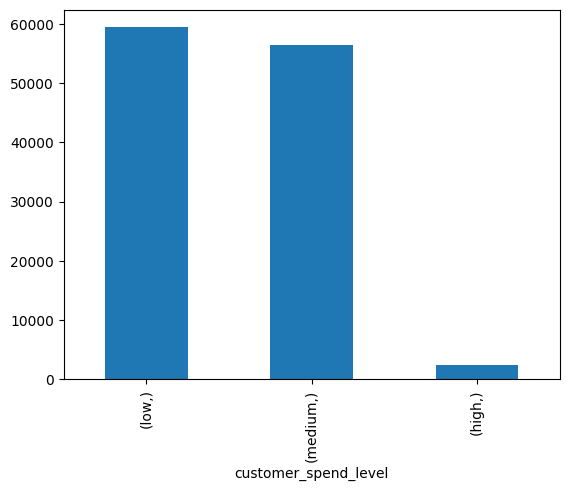

In [188]:
full_orders.select('customer_spend_level').toPandas().value_counts().plot.bar();

In [191]:
# day of week
from pyspark.sql.functions import expr

full_orders = full_orders.withColumn('weekday', when(expr("dayofweek(order_purchase_timestamp) in (1,7)"), 'weekend').otherwise('weekday'))
full_orders.show()

+--------------------+--------------------+---------------------+---------------------+--------------------------+--------------+--------------------+------------------------+-------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+-------------+------------------------+------------+--------------------+------------------+------------+-------------+------+---------------------+--------------------------+-----------------+--------------------+-----------------+-------------------+------------------+----------------+----------------+-----------------------+----------------------+--------------------+--------------------+--------------------+------------+--------------------+-------------------+-------------------+--------------------+------------+----------------------+-------------------+--------------------+-------+
|         customer_id|       customer_city|customer_geo_lat_mean|customer_geo_mean_ln